# Analyze false classifications

In [1]:
import pandas as pd

def load_df(model_type):
    path = f"../data/dfs/{model_type}/ReferenceErrorDetection_data_with_prompt_results.pkl"
    df = pd.read_pickle(path)
    return df

In [5]:
def remove_json_colons(json_text):
    if json_text and json_text.startswith("```json") and json_text.rstrip().endswith("```"):
        return json_text[7:-3]
    return json_text

In [6]:
import json

# Add extra columns for the model classification label and explanation by extracting the information from the JSON
# If the JSON is misformed due to leading ```json and trailing ``` then remove them
# Make sure that correct label and model label are both lower case and do not end with d (unsubstaniate instead of unsubstantiated)
def reshape_model_classification(df):
    for index, row in df.iterrows():
        if row['Reference Article Downloaded'] == 'Yes':
            try:
                row['Model Classification'] = remove_json_colons(row['Model Classification'])
                model_classification = json.loads(row['Model Classification'])
                label = model_classification['label'].lower()
                df.at[row.name, 'Model Classification Label'] = label if not label.endswith('d') else label[:-1]
                df.at[row.name, 'Model Classification Explanation'] = model_classification['explanation']
            except json.JSONDecodeError as e:
                print(f"Row {index} Model Classification could not be decoded: {e}")
                print(row['Model Classification'])
                df.at[row.name, 'Model Classification Label'] = None
                df.at[row.name, 'Model Classification Explanation'] = None
        else:
            df.at[row.name, 'Model Classification Label'] = None
            df.at[row.name, 'Model Classification Explanation'] = None
        df.at[row.name, 'Label'] = df.at[row.name, 'Label'].lower()
    return df

In [7]:
def find_false_classifications(df):

    # collect all row ids for false classifications
    # for each id there should be a dictionary with the target label and the model label
    false_classifications_ids = {}

    for index, row in df.iterrows():
        if row['Reference Article Downloaded'] == 'Yes':
            target_label = row['Label']
            model_label = row['Model Classification Label']
            
            if model_label not in ['unsubstantiate', 'partially substantiate', 'fully substantiate']:
                print(f"Row {index} Model Classification Label is not a valid label: {model_label}")
            elif target_label != model_label:
                false_classifications_ids[index] = {
                    'target_label': target_label,
                    'model_label': model_label
                }

    return false_classifications_ids

## Collect false classifications per model type

In [10]:
all_false_classifications = {}

In [11]:
model = "small_model"
df = load_df(model)
df = reshape_model_classification(df)
false_classifications = find_false_classifications(df)
all_false_classifications[model] = false_classifications

Row 22 Model Classification could not be decoded: Expecting property name enclosed in double quotes: line 2 column 1 (char 2)
{

Row 22 Model Classification Label is not a valid label: None


In [12]:
model = "full_model"
df = load_df(model)
df = reshape_model_classification(df)
false_classifications = find_false_classifications(df)
all_false_classifications[model] = false_classifications

Row 22 Model Classification could not be decoded: Expecting property name enclosed in double quotes: line 2 column 1 (char 2)
{

Row 22 Model Classification Label is not a valid label: None


In [13]:
model = "full_model_texts"
df = load_df(model)
df = reshape_model_classification(df)
false_classifications = find_false_classifications(df)
all_false_classifications[model] = false_classifications

In [14]:
all_false_classifications

{'small_model': {3: {'target_label': 'unsubstantiate',
   'model_label': 'partially substantiate'},
  7: {'target_label': 'unsubstantiate', 'model_label': 'fully substantiate'},
  46: {'target_label': 'unsubstantiate',
   'model_label': 'partially substantiate'},
  49: {'target_label': 'unsubstantiate',
   'model_label': 'partially substantiate'},
  52: {'target_label': 'unsubstantiate',
   'model_label': 'partially substantiate'},
  72: {'target_label': 'unsubstantiate', 'model_label': 'fully substantiate'},
  79: {'target_label': 'unsubstantiate',
   'model_label': 'partially substantiate'},
  80: {'target_label': 'unsubstantiate',
   'model_label': 'partially substantiate'},
  81: {'target_label': 'unsubstantiate',
   'model_label': 'partially substantiate'},
  82: {'target_label': 'unsubstantiate', 'model_label': 'fully substantiate'},
  83: {'target_label': 'unsubstantiate',
   'model_label': 'partially substantiate'},
  84: {'target_label': 'unsubstantiate', 'model_label': 'fully

In [18]:
# Reform the dictionary to group row ids by model types
model_types_per_id = {}

for model_type, false_classifications in all_false_classifications.items():
    for row_id in false_classifications.keys():
        if row_id not in model_types_per_id:
            model_types_per_id[row_id] = []
        model_types_per_id[row_id].append(model_type)

# Sort the dictionary by row ids
model_types_per_id = dict(sorted(model_types_per_id.items()))

In [19]:
model_types_per_id

{1: ['full_model_texts'],
 3: ['small_model', 'full_model', 'full_model_texts'],
 6: ['full_model_texts'],
 7: ['small_model', 'full_model'],
 10: ['full_model'],
 14: ['full_model_texts'],
 24: ['full_model', 'full_model_texts'],
 27: ['full_model_texts'],
 30: ['full_model', 'full_model_texts'],
 46: ['small_model', 'full_model', 'full_model_texts'],
 49: ['small_model', 'full_model', 'full_model_texts'],
 52: ['small_model', 'full_model', 'full_model_texts'],
 53: ['full_model'],
 56: ['full_model'],
 59: ['full_model_texts'],
 72: ['small_model', 'full_model'],
 73: ['full_model_texts'],
 75: ['full_model_texts'],
 79: ['small_model', 'full_model', 'full_model_texts'],
 80: ['small_model', 'full_model'],
 81: ['small_model', 'full_model', 'full_model_texts'],
 82: ['small_model', 'full_model', 'full_model_texts'],
 83: ['small_model', 'full_model', 'full_model_texts'],
 84: ['small_model', 'full_model', 'full_model_texts'],
 85: ['small_model', 'full_model', 'full_model_texts'],
 8

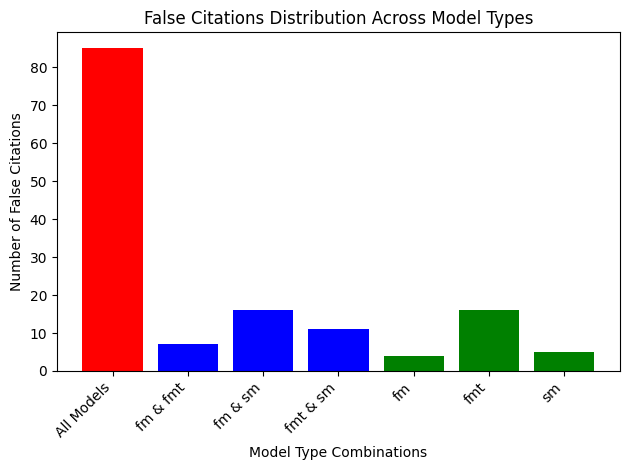

In [33]:
from collections import Counter

import matplotlib.pyplot as plt

# Abbreviations for model names
model_abbreviations = {
    "small_model": "sm",
    "full_model": "fm",
    "full_model_texts": "fmt"
}

# Count the occurrences of specific combinations of two models, individual models, and all models failing
specific_model_counts = Counter()

for models in model_types_per_id.values():
    if len(models) == 3:  # All models failed
        specific_model_counts["All Models"] += 1
    elif len(models) == 2:
        # Sort and abbreviate model names
        abbreviated_models = " & ".join(sorted(model_abbreviations[m] for m in models))
        specific_model_counts[abbreviated_models] += 1
    elif len(models) == 1:
        # Abbreviate single model name
        specific_model_counts[model_abbreviations[models[0]]] += 1

# Prepare data for plotting
# Sort categories: "All Models" first, then combinations of two models, then single models
categories = ["All Models"] + sorted(
    [key for key in specific_model_counts.keys() if " & " in key]
) + sorted(
    [key for key in specific_model_counts.keys() if key not in ["All Models"] and " & " not in key]
)
counts = [specific_model_counts[cat] for cat in categories]

# Assign colors: one color for "All Models", another for combinations of two models, and another for single models
colors = []
for category in categories:
    if category == "All Models":
        colors.append("red")  # Color for "All Models"
    elif " & " in category:
        colors.append("blue")  # Color for combinations of two models
    else:
        colors.append("green")  # Color for single models

# Create the bar plot
plt.bar(categories, counts, color=colors)
plt.xlabel('Model Type Combinations')
plt.ylabel('Number of False Citations')
plt.title('False Citations Distribution Across Model Types')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [36]:
ids_all_models_false = [row_id for row_id, models in model_types_per_id.items() if set(models) == set(model_abbreviations.keys())]
len(ids_all_models_false)

85

In [47]:
model = "full_model_texts"
df = load_df(model)
df_false_classifications = reshape_model_classification(df)
df_false_classifications = df[df.index.isin(ids_all_models_false)]
df_false_classifications.to_pickle(f"../data/dfs/{model}/ReferenceErrorDetection_data_results_false_classifications.pkl")

In [48]:
df_false_classifications.head()

,Source,Citing Article ID,Citing Article DOI,Citing Article Title,Citing Article Retracted,Citing Article Downloaded,Domain,Statement with Citation,Reference Article ID,Reference Article DOI,...,Reference Article PDF Available,Reference Article Retracted,Reference Article Downloaded,Label,Explanation,Top_3_Chunk_IDs,Top_3_Chunk_Texts,Model Classification,Model Classification Label,Model Classification Explanation
3,PubPeer,c003,10.1155/2022/2408685,The Choice of Anesthetic Drugs in Outpatient H...,Yes,Yes,Medicine,Research has shown that remimazolam tosylate e...,r004,10.1186/s12871-018-0543-3,...,Yes,No,Yes,unsubstantiate,Irrelevant,"[4947cbac-d6d7-4f50-9c75-4c101035c923, f9560dc...","[0.001) at 1 year, and 2% (-2 to 6%, non-signi...","{\n ""label"": ""Partially substantiate"",\n ...",partially substantiate,The reference article discusses the effects of...
46,PubPeer,c030,10.2298/gensr2201173y,Evaluation of genetic variability Rindera usin...,Yes,Yes,Biology,"Bees, flies, and honeybees [citation] pollinat...",r044,10.1098/rsbl.2019.0230,...,Yes,No,Yes,unsubstantiate,Different plant species,"[16a3cfad-5ac5-4128-aeb0-0eaa5fccccdb, d648b23...",[Introduction\nInsect pollination is a key eco...,"{\n ""label"": ""Partially substantiate"",\n ...",partially substantiate,The reference article discusses the effectiven...
49,PubPeer,c031,10.2298/gensr2102769m,Gene flow and genetic structure between popula...,Yes,Yes,Biology,Changes in environment often lead to variation...,r047,10.1038/s41392-021-00594-4,...,Yes,No,Yes,unsubstantiate,Irrelevant,"[c01bd902-060b-4cc7-b1ff-916d407cc9d9, 8c1ea04...","[2f ), indicating a reduced mitochondrial resp...","{\n ""label"": ""Partially substantiate"",\n ...",partially substantiate,The reference article discusses the role of RO...
52,PubPeer,c032,10.2298/gensr2103331l,Genetic diversity and gene-pool of Aegilops ta...,Yes,Yes,Biology,"Randomly amplified polymorphic DNA (RAPD), amp...",r050,10.3103/S0095452718040102,...,Yes,No,Yes,unsubstantiate,Different plant species,"[0c13ff08-9734-4b24-9083-8270a5cd9f52, 87474ee...",[Analyses\nFresh leaves were used randomly fro...,"{\n ""label"": ""Partially substantiate"",\n ...",partially substantiate,The reference article uses ISSR markers for ge...
79,PubPeer,c044,10.1007/s13204-021-02325-1,Solar radiation impact on ferrofluid convectio...,Yes,Yes,Physics,The nanoliquids are a mixture of typical fluid...,r076,10.1016/j.egyr.2021.04.046,...,Yes,No,Yes,unsubstantiate,Irrelevant,"[640ed69f-8b73-4897-bd3b-404ce88bb7f8, cf77e85...",[such as ethylene glycol and water with suitab...,"{\n ""label"": ""Partially substantiate"",\n ...",partially substantiate,The reference article discusses the use of nan...


In [53]:
def print_false_classification_rows(df, model_type):
    output_path = f"../data/false_classifications_{model_type}.txt"
    with open(output_path, 'w') as file:
        for index, row in df.iterrows():
            file.write(f"Row ID: {index}\n")
            file.write("-" * 80 + "\n")
            file.write(f"Target Label: {row['Label']}\n")
            file.write(f"Model Label: {row['Model Classification Label']}\n")
            file.write(f"Reference Article ID: {row['Reference Article ID']}\n")
            file.write(f"Statement: {row['Statement with Citation']}\n")
            file.write("\nTop 3 Chunk Texts:\n")
            for chunk in row['Top_3_Chunk_Texts']:
                file.write(f"- {chunk}\n")
            file.write("\nModel Explanation:\n")
            file.write(row['Model Classification Explanation'] if pd.notnull(row['Model Classification Explanation']) else "No explanation provided")
            file.write("\n" + "=" * 80 + "\n")

In [54]:
print_false_classification_rows(df_false_classifications, model)